In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tables

from lstchain.io.io import dl1_params_lstcam_key

from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

from ctapipe.image import tailcuts_clean
from lstchain.image.cleaning.cleaning import (
    tailcuts_clean_with_pedestal_threshold, 
    get_threshold_from_dl1_file
)

/home/pawel1/anaconda3/envs/cta/lib/python3.7/site-packages/corsikaio/subblocks/dtypes.py:20: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dict(**dt))


In [2]:
def get_pedestal_images(dl1_filename):
    "Function to get pedestal images from dl1 file"
    f = tables.open_file(dl1_filename)
    parameters = pd.read_hdf(dl1_filename, key=dl1_params_lstcam_key)
    image_table = f.root.dl1.event.telescope.image.LST_LSTCam
    image = image_table.col('image')
    params_pedestal_mask = (parameters['trigger_type'] == 32)
    ped_indices = np.array(parameters['event_id'][params_pedestal_mask])
    pedestal_mask = np.array([(True if evtid in ped_indices else False)
                              for evtid in image_table.col('event_id')])
    f.close()
    return image[pedestal_mask]

geom = CameraGeometry.from_name('LSTCam-002')
def make_image_plot(img, img_cleaned):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    disp0 = CameraDisplay(geom, ax=ax[0])
    disp0.image = img
    disp0.add_colorbar(ax=ax[0], label="signal [p.e.]")
    disp0.cmap = 'gnuplot2'
    ax[0].set_title("Dl1 image", fontsize=20)
    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])
    ax[0].set_xlabel("")
    ax[0].set_ylabel("")
    
    disp1 = CameraDisplay(geom, ax=ax[1])
    disp1.image = img_cleaned
    disp1.add_colorbar(ax=ax[1], label="signal [p.e.]")
    disp1.cmap = 'gnuplot2'
    ax[1].set_title("Dl1 cleaned image", fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xlabel("")
    ax[1].set_ylabel("")

In [3]:
path_to_dl1_data = "/media/pawel1/ADATA HD330/20191124/dl1_data/v0.5.1_v03/dl1_runs/dl1_LST-1.Run01627.0000.h5"
ped_images = get_pedestal_images(path_to_dl1_data) 

0


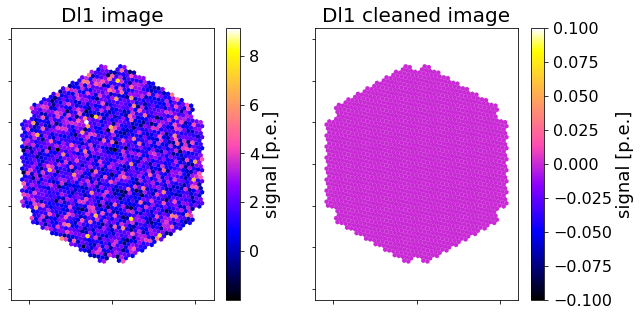

1


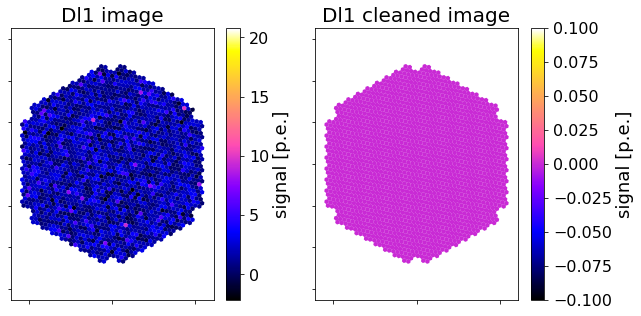

2


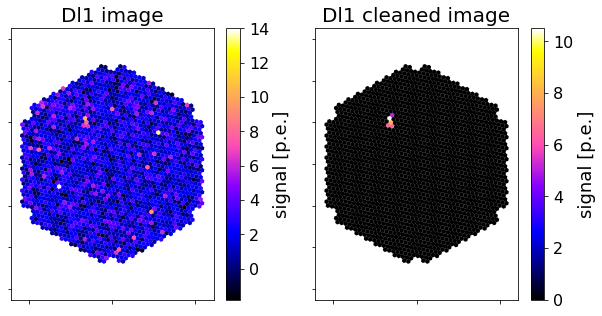

3


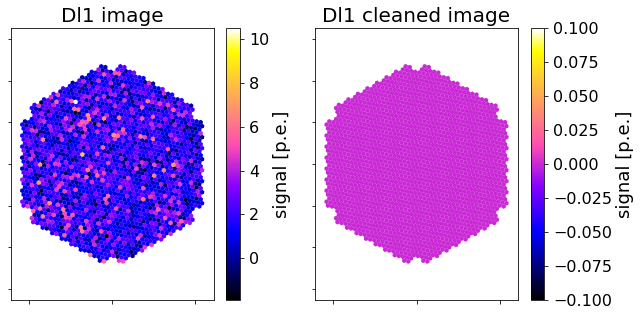

4


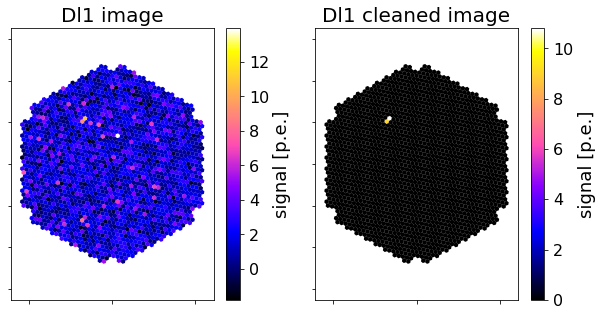

In [4]:
pic_th = 8
bound_th = 4
geom = CameraGeometry.from_name('LSTCam-002')
for i, image in enumerate(ped_images[5:10]):
    print(i)
    img = image.copy()
    clean = tailcuts_clean(
                       geom,
                       img,
                       picture_thresh=pic_th,
                       boundary_thresh=bound_th,
                       keep_isolated_pixels=False,
                       min_number_picture_neighbors=1,
                      )
    cleaned = img.copy()
    cleaned[~clean] = 0.0
    make_image_plot(img, cleaned)
    plt.show()

# New cleaning method: Tailcut cleaning with additional threshold
* Pedestal calculated using interleaved events.
* Added additional threshold to tailcut cleaning method.
* Cleaning the most noisy pixels (for example around the star location)

Threshold for each pixel is define as: ***threshold = pedestal_bias + sigma***$\cdot$***pedestal_rms*** 

***sigma - parameter to set***


Recommended threshold for cleaning:
* galactic source: picture_thresh=8, boundary_thresh=4, sigma=3
* extragalactic source: picture_thresh=6, boundary_thresh=3, sigma=2.5

0


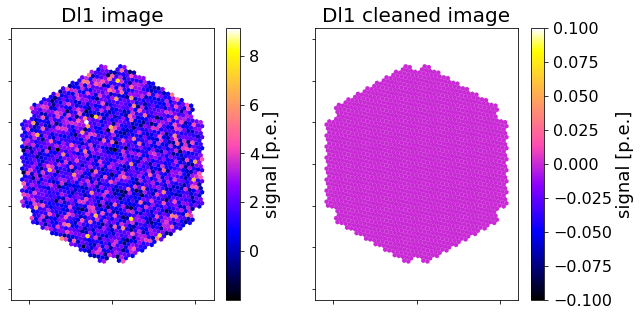

1


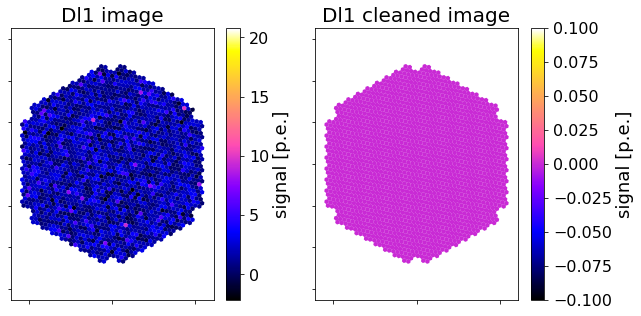

2


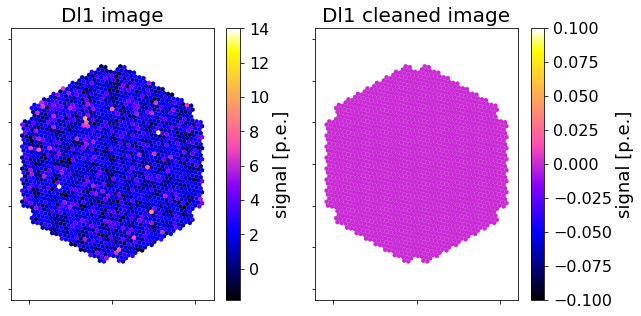

3


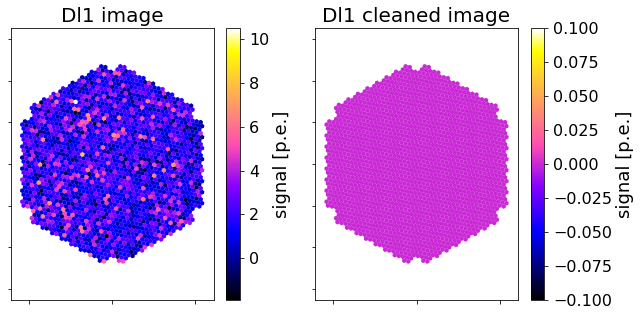

4


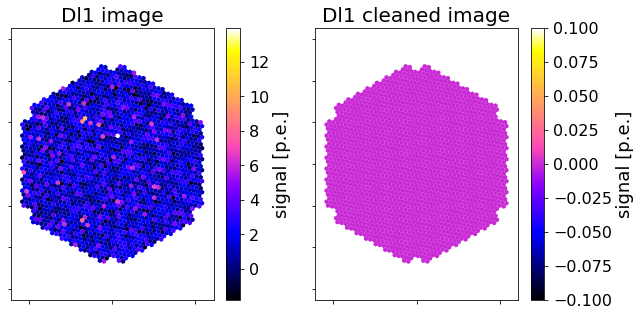

In [5]:
pic_th = 8
bound_th = 4
sigma = 3
th_ped_interleave = get_threshold_from_dl1_file(path_to_dl1_data, sigma)

geom = CameraGeometry.from_name('LSTCam-002')
for i, image in enumerate(ped_images[5:10]):
    print(i)
    img = image.copy()
    clean_sigma =  tailcuts_clean_with_pedestal_threshold(
                            geom,
                            img,
                            th_ped_interleave,
                            picture_thresh=pic_th,
                            boundary_thresh=bound_th,
                            keep_isolated_pixels=False,
                            min_number_picture_neighbors=1,
                        )
    
    cleaned_sigma = img.copy()
    cleaned_sigma[~clean_sigma] = 0.0
    make_image_plot(img, cleaned_sigma)
    plt.show()